In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

import mu2

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
const.BETA4

32.70989286766126

In [3]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [4]:
R_mm = 1.5
f = 20
qmax = f*2/R_mm
nq = 520

qmesh = utility.log_mesh(0, qmax, nq)
mm = LocalSystem(R_mm, qmesh=(*qmesh, qmax))
vtilde_mm = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)
kcd_0_mm = mu2.cc.cscatter.kcotdelta_py(0, vtilde_mm, mm.q, mm.wq, mm.q_max, 0, 2*const.MU)

In [5]:
rgf_lo = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14.txt')
Rs = rgf_lo[:, 0]
gs_lo = rgf_lo[:, 1]

In [7]:
Ri = Rs[-1]
gi = gs_lo[-1]

nq = 520
qmax = f*2/Ri
qmesh = utility.log_mesh(0, qmax, nq)

for n in np.arange(2000, 4001, 200):
    ls = LocalSystem(Ri, qmesh=(*qmesh, qmax), rmesh=utility.log_mesh(0, 10*const.BETA4, n))
    print(n, (kcd_0_mm - mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(gi, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)) / kcd_0_mm)

2000 1.2980393652113369e-05
2200 0.0010652174672846054
2400 0.0003881118719410712
2600 0.001673812239965603
2800 0.0002088584259462758
3000 0.00026945872293986805
3200 -1.7118705098352105e-05
3400 -0.0004854587571203236
3600 -0.00023891255765837456
3800 -0.0003916208836549959
4000 0.00013390327870356294


In [12]:
Ri = Rs[-1]
gi = gs_lo[-1]

nq = 520
qmax = f*2/Ri
qmesh = utility.log_mesh(0, qmax, nq)

for m in np.arange(10, 16):
    for n in np.arange(4000, 4001, 100):
        ls = LocalSystem(Ri, qmesh=(*qmesh, qmax), rmesh=utility.log_mesh(0, m*const.BETA4, n))
        print(ls.bound_state_spectrum(gi, 0))
        print(m, n, mu2.cc.cscatter.kcotdelta_py(
            0, ls.v_tilde + ls.counterterm.gen(gi, 0), ls.q, ls.wq, qmax, 0, 2*const.MU
        ))

40 5000 0.015591815256303876
42 5000 0.015583445552504698
44 5000 0.015566106976984639
46 5000 0.015568794486090252
48 5000 0.015554563607767835
50 5000 0.015551290749682933


In [51]:
Ri = Rs[0]
f = 20
qmax = f*2/Ri
nq = 520
qmesh = utility.log_mesh(0, qmax, nq)
rmesh = utility.log_mesh(0, 40*const.BETA4, 5000)
ls = LocalSystem(Ri, qmesh=(*qmesh, qmax), rmesh=rmesh)

In [52]:
def kcd0(g, ls):
    return mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(g, 0), ls.q, ls.wq, qmax, 0, 2*const.MU
    )

In [53]:
guess = -0.686
-1/kcd0(guess, ls), ls.bound_state_spectrum(guess, 0).size

(-60.21909717593485, 14)

In [54]:
NUM_STATES = 14

In [55]:
def froot(g, ls, qmax):
    spectrum = ls.bound_state_spectrum(g, 0)
    assert spectrum.size == NUM_STATES, f'There are {spectrum.size} bounds states.'
    return (kcd_0_mm - mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(g, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)) / kcd_0_mm

In [56]:
froot(guess, ls, qmax)

-0.014029755059985148

In [57]:
class Data:
    def __init__(self, ls, g_lo, qmax):
        self.a0 = -1/mu2.cc.cscatter.kcotdelta_py(
            0, ls.v_tilde + ls.counterterm.gen(g_lo, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)
        evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(g_lo, 0), 1, ls.q, ls.wq)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.g_lo = g_lo

In [67]:
glos = np.zeros(Rs.size)
data = []

for i in range(Rs.size):
    Ri = Rs[i]
    guess = gs_lo[i]
    qmax = f*2/Ri
    qmesh = utility.log_mesh(0, qmax, nq)
    ls = LocalSystem(Ri, qmesh=(*qmesh, qmax), rmesh=rmesh)
    result = optimize.fsolve(froot, guess, args=(ls, qmax), xtol=1e-12)
    glo = result[0]
    
    glos[i] = glo
    data.append(Data(ls, glo, qmax))
    
#     if i < 5:
#         guess = glo
#     else:
#         curve = interp1d(Rs[i-5:i], glos[i-5:i], kind='cubic', fill_value='extrapolate')
#         try:
#             guess = curve(Rs[i+1])
#         except:
#             break
    
    print(f'i = {i}  R = {Ri:.4e}  g_LO = {glo:.4e}')

KeyboardInterrupt: 

In [59]:
len(data)

98

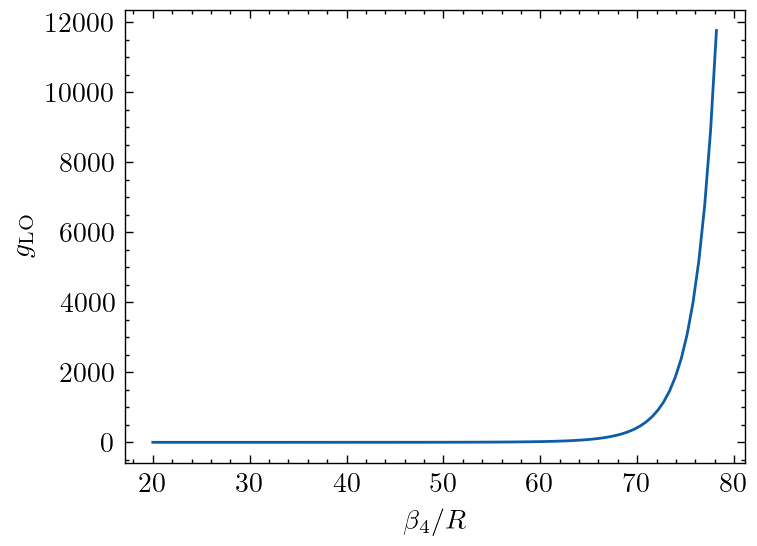

In [60]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(const.BETA4/Rs[:i], glos[:i])

# ax.set_ylim([-1, 1])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$g_{\rm LO}$');

In [61]:
lo_specs = np.array([d.lo_evals for d in data])

In [62]:
-1/kcd_0_mm - np.array([d.a0 for d in data])

array([-5.82645043e-13,  8.24229573e-13,  5.54223334e-13,  4.40536496e-13,
       -3.48165941e-13,  0.00000000e+00, -1.42108547e-13, -3.90798505e-13,
       -3.48165941e-13,  4.54747351e-13,  1.42108547e-13, -3.48165941e-13,
        8.38440428e-13, -2.30215846e-12, -4.54747351e-13,  5.04485342e-13,
       -2.20268248e-13,  0.00000000e+00,  1.42108547e-14, -8.66862138e-13,
        6.32383035e-13, -2.48689958e-13,  1.13686838e-13, -4.97379915e-14,
        5.04485342e-13, -3.12638804e-13,  9.23705556e-14,  4.97379915e-14,
        4.40536496e-13,  3.48165941e-13,  6.75015599e-13,  1.07291953e-12,
       -1.42108547e-13, -6.32383035e-13, -2.17426077e-12, -1.56319402e-13,
        1.42108547e-13, -3.26849658e-13,  3.19744231e-13, -2.20268248e-13,
       -1.56319402e-13,  5.32907052e-13, -7.24753590e-13,  7.10542736e-13,
        5.32907052e-13,  6.39488462e-14, -5.18696197e-13, -4.54747351e-13,
        2.98427949e-13,  6.39488462e-14, -2.06057393e-13, -5.82645043e-13,
       -7.81597009e-14,  

In [63]:
mm_evals, mm_evecs = bind.bound_states(vtilde_mm, 0, 0, mm.q, mm.wq)
mm_evals

array([-0.06476099, -0.04422774, -0.02740748, -0.01466226, -0.00611664,
       -0.00156342, -0.00012025])

In [64]:
j = len(data)

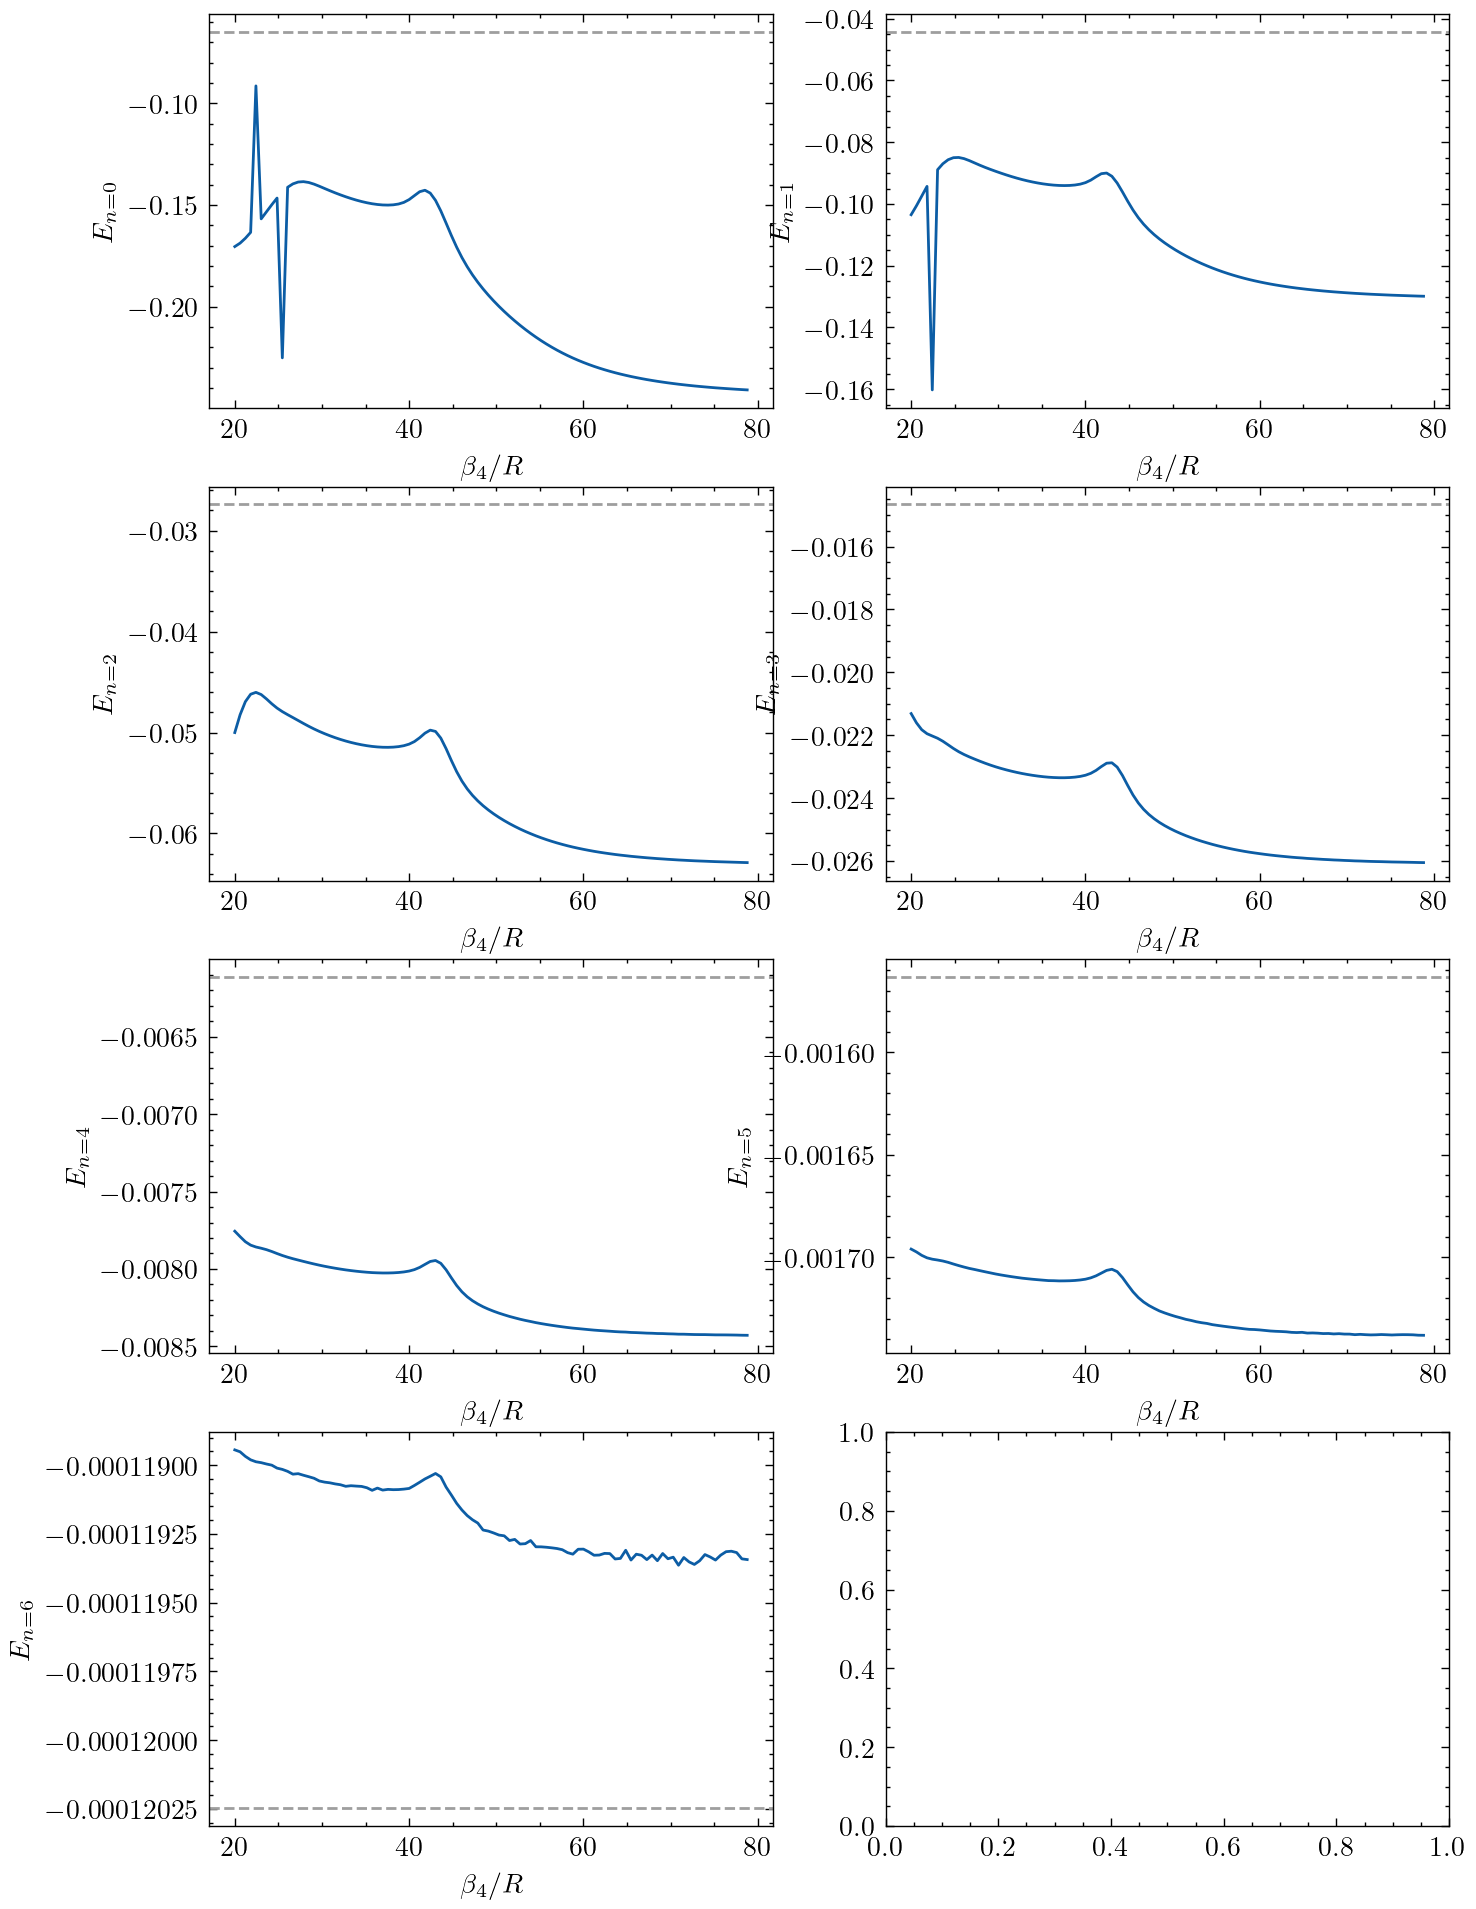

In [65]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs[:j], lo_specs[:, i+7])
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i));

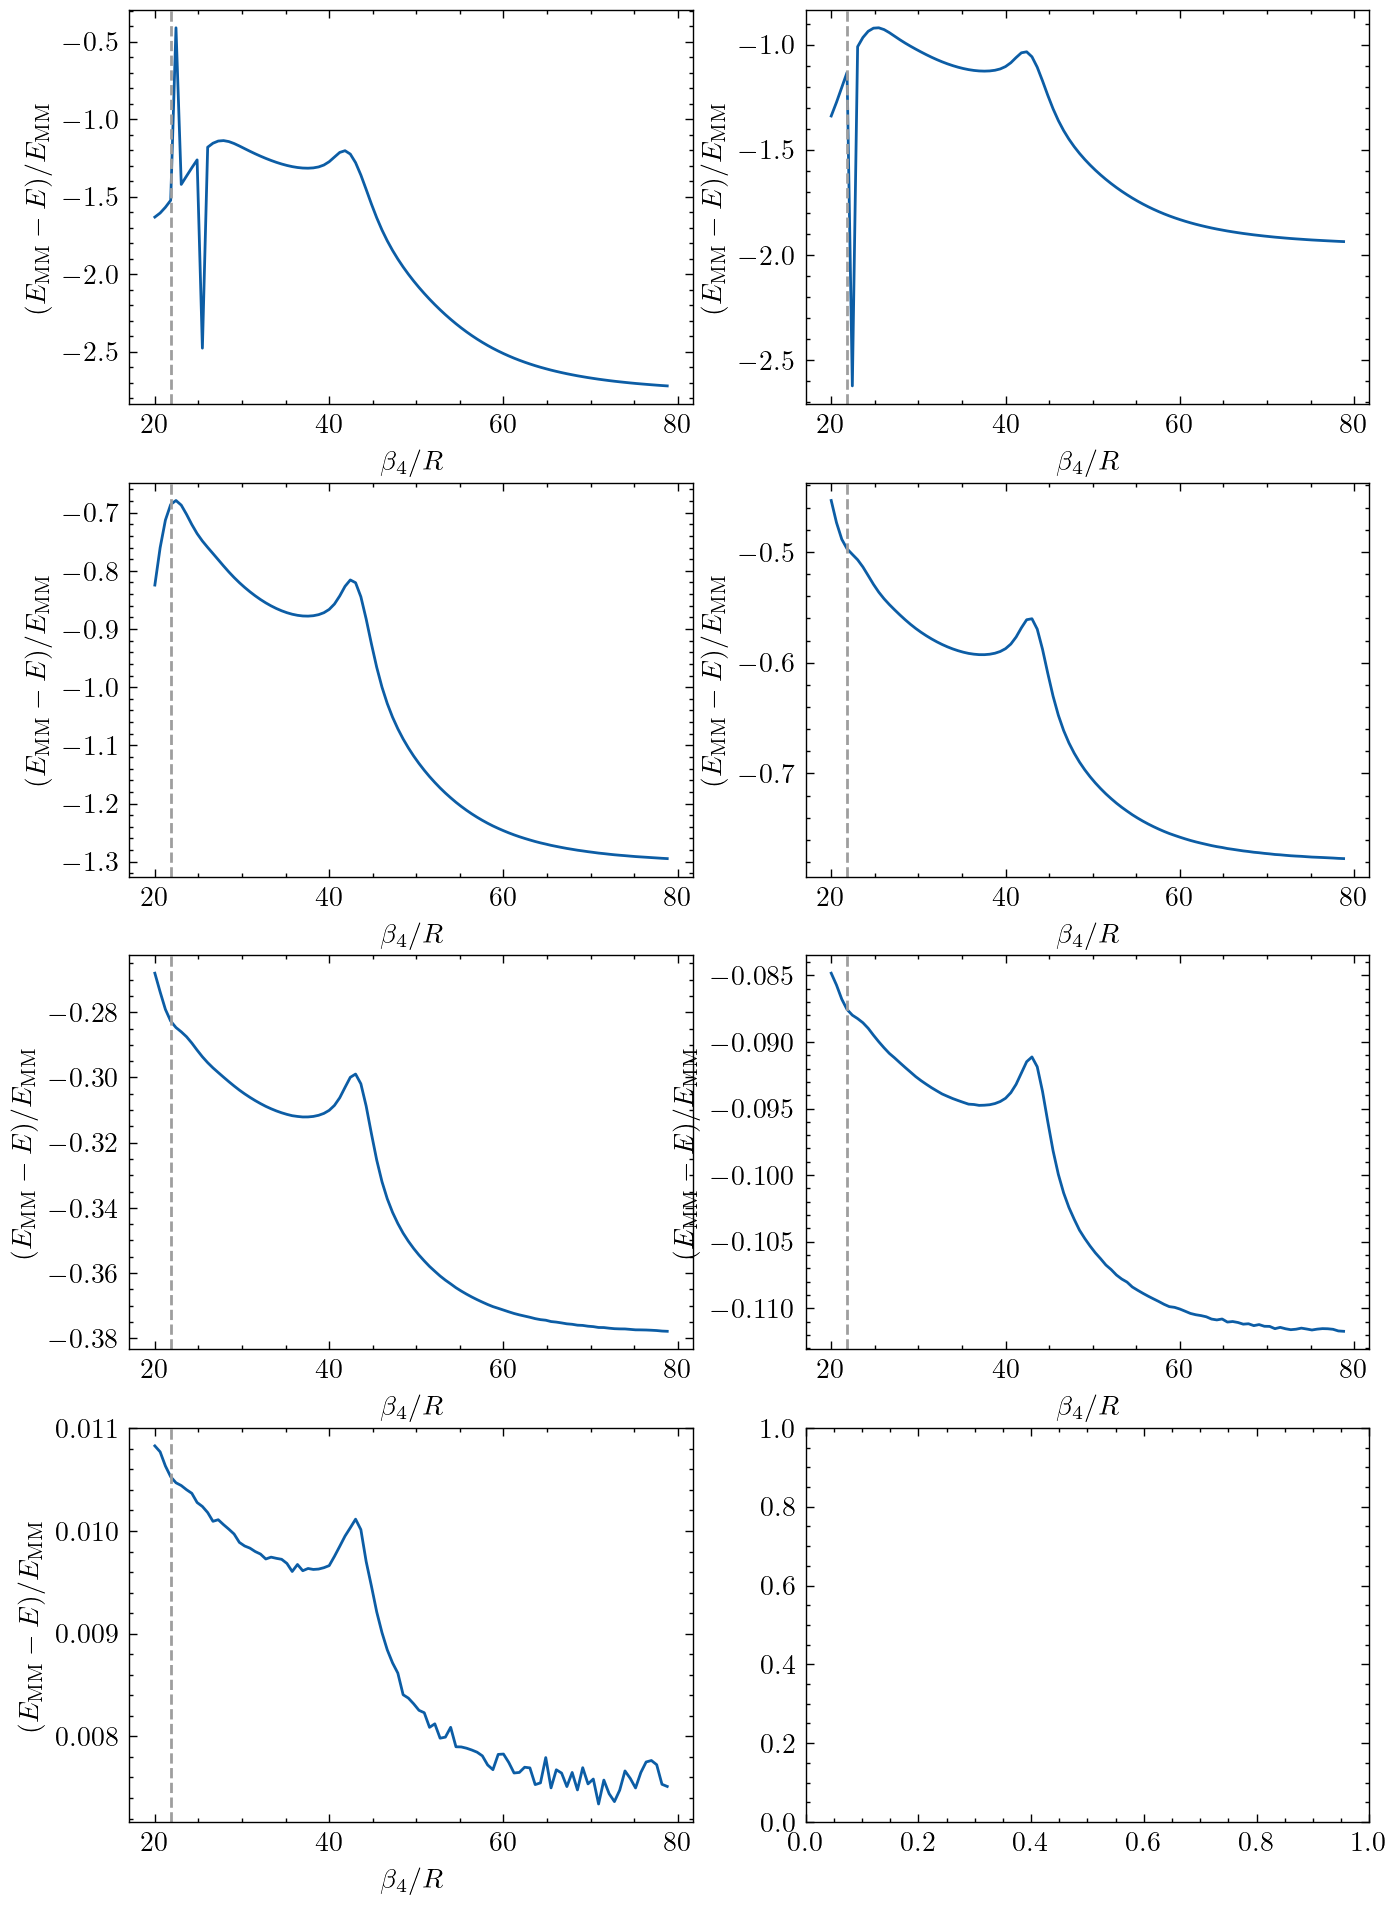

In [68]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs[:j], (mm_evals[i] - lo_specs[:, i+7])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

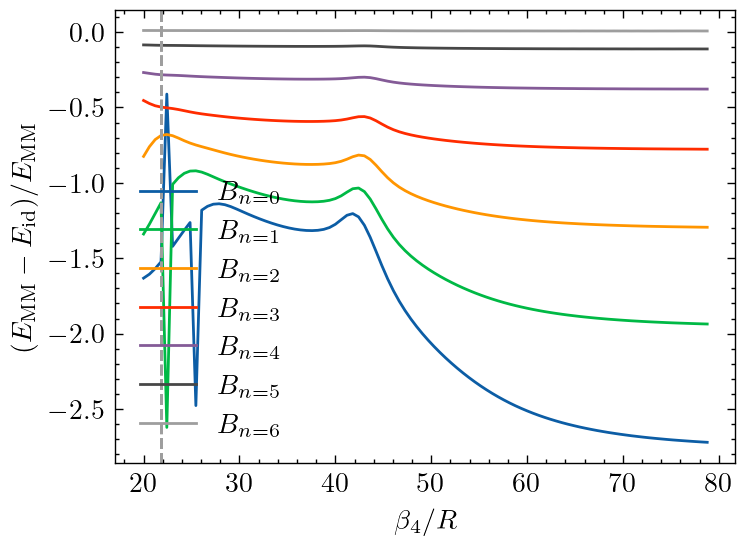

In [69]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs[:j], (mm_evals[i] - lo_specs[:, i+7])/mm_evals[i], label='$B_{n=%d}$' % (i))
    ax.set_xlabel(r'$\beta_4/R$')
    ax.set_ylabel(r'$(E_{\rm MM}-E_{\rm id})/E_{\rm MM}$')
    ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')
ax.legend();

In [41]:
np.savetxt(f'rgflow_local_lo_a0_fix_hpp_n_{NUM_STATES}.txt', np.vstack((Rs[:j], glos[:j])).T, header='R  g_LO')

In [45]:
lo_specs[-1, 7:]

array([-2.40941171e-01, -1.29842910e-01, -6.28732547e-02, -2.60435556e-02,
       -8.42404202e-03, -1.73690985e-03, -1.19178460e-04])

In [43]:
np.savetxt(f'spectra_local_lo_a0_fix_hpp_n_{NUM_STATES}.txt', np.vstack((Rs[:j], lo_specs[:, 7:].T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6 ')